# Project 2: Topic Classification

In this project, you'll work with text data from newsgroup postings on a variety of topics. You'll train classifiers to distinguish between the topics based on the text of the posts. Whereas with digit classification, the input is relatively dense: a 28x28 matrix of pixels, many of which are non-zero, here we'll represent each document with a "bag-of-words" model. As you'll see, this makes the feature representation quite sparse -- only a few words of the total vocabulary are active in any given document. The bag-of-words assumption here is that the label depends only on the words; their order is not important.

The SK-learn documentation on feature extraction will prove useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [2]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

Load the data, stripping out metadata so that we learn classifiers that only use textual features. By default, newsgroups data is split into train and test sets. We further split the test so we have a dev set. Note that we specify 4 categories to use for this project. If you remove the categories argument from the fetch function, you'll get all 20 categories.

In [3]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=categories)

num_test = len(newsgroups_test.target)
test_data, test_labels = newsgroups_test.data[num_test/2:], newsgroups_test.target[num_test/2:]
dev_data, dev_labels = newsgroups_test.data[:num_test/2], newsgroups_test.target[:num_test/2]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print 'training label shape:', train_labels.shape
print 'test label shape:', test_labels.shape
print 'dev label shape:', dev_labels.shape
print 'labels names:', newsgroups_train.target_names

training label shape: (2034L,)
test label shape: (677L,)
dev label shape: (676L,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


(1) For each of the first 5 training examples, print the text of the message along with the label.

In [3]:
def P1(num_examples=5):
### STUDENT START ###
    # simple iteration to return the requested examples and labels
    for i in range(num_examples):
        message_text = train_data[i]
        raw_label = train_labels[i]
        cat = categories[raw_label]
        print 'For example {}, the label is {}, which corresponds to the category of '.format(i+1, raw_label)+str(cat)+'.'
        print 'The corresponding message is :'
        print''
        print message_text
        print''
### STUDENT END ###
P1()

For example 1, the label is 1, which corresponds to the category of talk.religion.misc.
The corresponding message is :

Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych

For example 2, the label is 3, which corresponds to the category of sci.space.
The corresponding message is :



Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with 

(2) Use CountVectorizer to turn the raw training text into feature vectors. You should use the fit_transform function, which makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").

The vectorizer has a lot of options. To get familiar with some of them, write code to answer these questions:

a. The output of the transform (also of fit_transform) is a sparse matrix: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. What is the size of the vocabulary? What is the average number of non-zero features per example? What fraction of the entries in the matrix are non-zero? Hint: use "nnz" and "shape" attributes.

b. What are the 0th and last feature strings (in alphabetical order)? Hint: use the vectorizer's get_feature_names function.

c. Specify your own vocabulary with 4 words: ["atheism", "graphics", "space", "religion"]. Confirm the training vectors are appropriately shaped. Now what's the average number of non-zero features per example?

d. Instead of extracting unigram word features, use "analyzer" and "ngram_range" to extract bigram and trigram character features. What size vocabulary does this yield?

e. Use the "min_df" argument to prune words that appear in fewer than 10 documents. What size vocabulary does this yield?

f. Using the standard CountVectorizer, what fraction of the words in the dev data are missing from the vocabulary? Hint: build a vocabulary for both train and dev and look at the size of the difference.

In [35]:
def P2():
### STUDENT START ###
    vec = CountVectorizer()
    x = vec.fit_transform(train_data)
    print 'The size of the vocabulary is {} words derived from {} examples.'.format(len(vec.vocabulary_), len(train_data))
    print ''
    
    #force calculation and roudning of non-zero features, mostly we assume not possible for partial feature.
    nonzeroReps = []
    for mat in x:
        listRep = [int(y) for y in mat.todense().tolist()[0]]
        nonzeroReps += [len(listRep) - listRep.count(0)]   
    print 'The average number of non-zero features per example is {}.'.format(round(np.average(nonzeroReps),0))
    print ''
    
    totalFraction = x.nnz*1.0 / (x.shape[0]*x.shape[1])
    print 'The fraction of total entries that are non-zero is {:.2} percent.'.format(totalFraction*100)
    print ''
    
    ##start of b.
    first, last = str(vec.get_feature_names()[0]),str(vec.get_feature_names()[-1])
    print "The first feature is "+first+", and the last is "+last+"."
    print ''
    
    ##start of c.
    newVocab =  ["atheism", "graphics", "space", "religion"]
    vec1 = CountVectorizer(vocabulary=newVocab)
    x1 = vec1.fit_transform(train_data)
    
    nonzeroReps1 = []
    for mat in x1:
        listRep = [int(y) for y in mat.todense().tolist()[0]]
        nonzeroReps1 += [len(listRep) - listRep.count(0)]   
    out = round(np.average(nonzeroReps1),0)
    print 'The average number of non-zero with reduced dictionary is features per example with is {}.'.format(out)
    print ''
    
    #start of d.
    vecBi = CountVectorizer(analyzer='char',ngram_range=(2,2))
    x2 = vecBi.fit_transform(train_data)
    print 'The size of the bigram vocabulary is {} words.'.format(len(vecBi.vocabulary_))
    print ''
    
    vecTri = CountVectorizer(analyzer='char',ngram_range=(3,3))
    x2 = vecTri.fit_transform(train_data)
    print 'The size of the trigram vocabulary is {} words.'.format(len(vecTri.vocabulary_))
    print ''
    
    #start of e.
    vecMin10 = CountVectorizer(min_df=10)
    x2 = vecMin10.fit_transform(train_data)
    len(vecMin10.vocabulary_)
    print 'When enforcing a cutoff of 10 documents, the vocabulary is {} words.'.format(len(vecMin10.vocabulary_))
    print ''
    
    #start of f.
    trainVocab = vec.vocabulary_
    xDev = vec.fit_transform(dev_data)
    devVocab = vec.vocabulary_

    diff = len(devVocab)-len(list(set(trainVocab.keys()) & set(devVocab.keys())))
    print 'In the dev vocabulary there are {} words missing from the train vocabulary.'.format(diff)
    
    
### STUDENT END ###
P2()

The size of the vocabulary is 26879 words derived from 2034 examples.

The average number of non-zero features per example is 97.0.

The fraction of total entries that are non-zero is 0.36 percent.

The first feature is 00, and the last is zyxel.

The average number of non-zero with reduced dictionary is features per example with is 0.0.

The size of the bigram vocabulary is 3291 words.

The size of the trigram vocabulary is 32187 words.

When enforcing a cutoff of 10 documents, the vocabulary is 3064 words.

In the dev vocabulary there are 4027 words missing from the train vocabulary.


(3) Use the default CountVectorizer options and report the f1 score (use metrics.f1_score) for a k nearest neighbors classifier; find the optimal value for k. Also fit a Multinomial Naive Bayes model and find the optimal value for alpha. Finally, fit a logistic regression model and find the optimal value for the regularization strength C using l2 regularization. A few questions:

a. Why doesn't nearest neighbors work well for this problem?

b. Any ideas why logistic regression doesn't work as well as Naive Bayes?

c. Logistic regression estimates a weight vector for each class, which you can access with the coef\_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.

In [133]:
def P3():
### STUDENT START ###
    vec = CountVectorizer()
    x = vec.fit_transform(train_data).toarray()
    dev = vec.transform(dev_data).toarray()
   
    #fit and optimize across k, note the 3Fold KValidation takes time so
    #small number of k's tried
    nn = KNeighborsClassifier()
    k = {'n_neighbors':[1,2,5,10,20]}
    nn = GridSearchCV(nn,k)
    nn.fit(x,train_labels)
    bestN = nn.best_params_.values()[0]
    print 'The optimal choice of k from the given set is {}'.format(bestN)
    print ''
    
    #define predictions and calc F1
    preds = nn.predict(dev)
    f1 = metrics.f1_score(dev_labels,preds)
    print 'The F1 score for K-Nearest Neighbors is {:.4}'.format(f1)
    print ''
    
    #fit multinomial
    mb = MultinomialNB()
    alphas = {'alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
    mb = GridSearchCV(mb,alphas)
    mb.fit(x,train_labels)
    bestAlpha = mb.best_params_.values()[0]
    print 'The optimal choice of alpha from the given set is {}'.format(bestAlpha)
    print ''

    #define predictions and calc F1
    predsMB = mb.predict(dev)
    f1MB = metrics.f1_score(dev_labels,predsMB)
    print 'The F1 score for Multinomial Naive Bayes is {:.4}'.format(f1MB)
    print ''
    
    #fit Logistic Regression
    Cs = {'C': [0.001, 0.01, 0.1, 1.0, 2.0, 10.0]}
    lr = LogisticRegression(penalty = 'l2')
    lr = GridSearchCV(lr,Cs)
    lr.fit(x,train_labels)
    bestC = lr.best_params_.values()[0]
    print 'The optimal choice of C from the given set is {}'.format(bestC)
    print''
    
    #define predictions and calc F1
    predsLR = lr.predict(dev)
    f1LR = metrics.f1_score(dev_labels,predsLR)
    print 'The F1 score for Logistic Regression is {:.4}'.format(f1LR)
    print ''
    
    #Calc and print c's to weight values
    for i in Cs.values()[0]:
        lr1 = LogisticRegression(penalty = 'l2', C=i)
        lr1.fit(x,train_labels)
        weights = [sum(y) for y in lr1.coef_**2]
        print 'For C value of {}, the sums of weight vectors squared are:'.format(i) 
        print weights
        print ''
### STUDENT END ###
P3()

The optimal choice of k from the given set is 20



C:\Enthought\User\lib\site-packages\sklearn\metrics\classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)


The F1 score for K-Nearest Neighbors is 0.422

The optimal choice of alpha from the given set is 0.01

The F1 score for Multinomial Naive Bayes is 0.7752



C:\Enthought\User\lib\site-packages\sklearn\metrics\classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)


The optimal choice of alpha from the given set is 0.1

The F1 score for Logistic Regression is 0.6966



C:\Enthought\User\lib\site-packages\sklearn\metrics\classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)


For C value of 0.001, the sums of weight vectors squared are:
[0.16509345166787442, 0.20095274690581966, 0.18067093754393232, 0.18724278437848826]

For C value of 0.01, the sums of weight vectors squared are:
[2.5414804607462353, 2.9397093683563731, 2.8624689485521828, 2.2500287477622374]

For C value of 0.1, the sums of weight vectors squared are:
[27.127547660850993, 24.649911518065075, 27.458368829029606, 23.018063062002721]

For C value of 1.0, the sums of weight vectors squared are:
[166.95971525594615, 130.86900902202387, 158.03620136068233, 145.69588042862713]

For C value of 2.0, the sums of weight vectors squared are:
[257.52060888338974, 197.88937739517738, 240.00462602916397, 226.71480174078738]

For C value of 10.0, the sums of weight vectors squared are:
[586.67761400561096, 447.9390597589221, 540.35981422466079, 530.78678792785456]



ANSWER:  I believe nearest neighbors will suffer from an incomplete vocabulary leading to a much higher ambiguity of messages that contain some parts of a similar vocabulary.  This is then further exacerbated when calculating the distnace between points where certain words that are common to multiple classes may outweigh the importance of a singular missing value of a more unique word.  The key difference between Naive Bayes and Logistic Regression is the assumption of independence in features that the former employs.  From a document classification stanpoint, this may be beneficail especially when the vocabulary derived from the training data is not complete.  As noted above, there is ~20% of the dev data vocabulary missing from the training dictionary, so more singular, distinct words might want to be given the maximum weight if they are strongly related to a class as opposed to a diminishing magnitude caused by correlation with other features.  C is inversely related to regularization, so the smaller values lead to a higher penalty function.  So the more punitive regularization term will restrict overfitting weight values.  Thus as we relax the regularization (increase C), we would expect higher and higher magnitudes, which, when squared, yield higher sums.

(4) Train a logistic regression model. Find the 5 features with the largest weights for each label -- 20 features in total. Create a table with 20 rows and 4 columns that shows the weight for each of these features for each of the labels. Create the table again with bigram features. Any surprising features in this table?

In [54]:
def P4():
### STUDENT START ###
    #function to create the ngram table
    def createTable(n_gram):
        #fit the regression
        vec = CountVectorizer(ngram_range =(n_gram, n_gram))
        x = vec.fit_transform(train_data).toarray()
        dev = vec.transform(dev_data).toarray()
    
        lr = LogisticRegression(penalty = 'l2', C=0.1)
        lr.fit(x,train_labels)
        featureWeights = lr.coef_
    
        allWeights = []
        for i in featureWeights:
            magnitude = abs(i)
            indices = [x for x in np.argsort(magnitude)[-5:]]
            allWeights += indices
    
        rownames = [str(vec.vocabulary_.keys()[y]) for y in allWeights]
    
        #create array that will be turned into table
        arrayData = []
        for index in allWeights:
            row = [featureWeights[0][index], featureWeights[1][index], featureWeights[2][index], featureWeights[3][index]]
            arrayData.append(row)
        print pd.DataFrame(arrayData, index = rownames, columns=categories)
    
    print 'For unigram:'
    createTable(n_gram=1)
    print ''
    
    print 'For bigram:'
    createTable(n_gram=2)
    
### Student End ###
P4()


For unigram:
               alt.atheism  talk.religion.misc  comp.graphics  sci.space
condescending     0.461523           -0.079333      -0.158391  -0.295264
alphachannel      0.478081           -0.120405      -0.167847  -0.227744
visitor           0.493939           -0.298727      -0.393228   0.003990
imaginative       0.495522           -0.207186      -0.199910  -0.267768
2009             -0.655138           -0.713828       1.258800  -0.590132
pi1              -0.039748            0.558916      -0.329046  -0.228741
aneutronic       -0.177352            0.641005      -0.421576  -0.288189
80               -0.263612            0.641869      -0.367629  -0.216023
2009             -0.655138           -0.713828       1.258800  -0.590132
arcjets          -0.411104            1.007303      -0.651122  -0.372192
vest              0.085460           -0.430927      -0.507656   0.270640
tickets          -0.273491           -0.261667       0.540881  -0.253080
millernw         -0.217556           -

ANSWER:  Off the bat we notice and immediate decreases in weight magnitude in the bigram vs unigram tables.  I found it surprising to see some numerical values.  We also see that there are some tokens which are in the top five magnitude weights for multiple classes, such as 'arcjets' and 'most humane'.

(5) Try to improve the logistic regression classifier by passing a custom preprocessor to CountVectorizer. The preprocessing function runs on the raw text, before it is split into words by the tokenizer. Your preprocessor should try to normalize the input in various ways to improve generalization. For example, try lowercasing everything, replacing sequences of numbers with a single token, removing various other non-letter characters, and shortening long words. If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular. With your new preprocessor, how much did you reduce the size of the dictionary?

For reference, I was able to improve dev F1 by 2 points.

In [90]:
def empty_preprocessor(s):
    return s

def better_preprocessor(s):
### STUDENT START ###
    # replcace all long decimals with one token
    s = re.sub('\.\d+','\.\d',s)
    
    #replace any strings longer than 20 with 15
    s = re.sub('[a-zA-Z_]{15,}', '[a-zA-Z_]{10,}',s)

    return s
### STUDENT END ###

def P5():
### STUDENT START ###

    #basic LR model with different preprocessing
    def calcF1(processFunction):
        vec = CountVectorizer(preprocessor=processFunction)
        x = vec.fit_transform(train_data).toarray()
        dev = vec.transform(dev_data).toarray()
        
        lr = LogisticRegression(penalty = 'l2', C= 0.1)
        lr.fit(x,train_labels)
        predsLR = lr.predict(dev)
        f1LR = metrics.f1_score(dev_labels,predsLR)
        vocablen = len(vec.vocabulary_)
        return f1LR, vocablen
    
    empty, oldLen = calcF1(empty_preprocessor)
    print 'The F1 score for no PreProcessing is {:.4}'.format(empty)
    print ''
    
    preProcessed, newLen = calcF1(better_preprocessor)
    print 'The F1 score for custom Preprocessing is {:.4}'.format(preProcessed)
    print ''
    
    print 'The new shortened vocabulary is reduced by {} words.'.format(oldLen-newLen)

### STUDENT END ###
P5()

C:\Enthought\User\lib\site-packages\sklearn\metrics\classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)


The F1 score for no PreProcessing is 0.7014

The F1 score for custom Preprocessing is 0.7031

The new shortened vocabulary is reduced by 360 words.


C:\Enthought\User\lib\site-packages\sklearn\metrics\classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)


(6) The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. That is, logistic regression seeks the set of weights that minimizes errors in the training data AND has a small size. The default regularization, L2, computes this size as the sum of the squared weights (see P3, above). L1 regularization computes this size as the sum of the absolute values of the weights. The result is that whereas L2 regularization makes all the weights relatively small, L1 regularization drives lots of the weights to 0, effectively removing unimportant features.

Train a logistic regression model using a "l1" penalty. Output the number of learned weights that are not equal to zero. How does this compare to the number of non-zero weights you get with "l2"? Now, reduce the size of the vocabulary by keeping only those features that have at least one non-zero weight and retrain a model using "l2".

Make a plot showing accuracy of the re-trained model vs. the vocabulary size you get when pruning unused features by adjusting the C parameter.

Note: The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.01 (the default is .0001).

The number of nonzero weights using L1 is 206.

The number of nonzero weights using L2 is 26879.



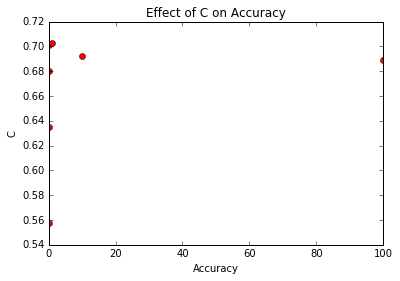

In [48]:
def P6():
    # Keep this random seed here to make comparison easier.
    np.random.seed(0)

    ### STUDENT START ###
    #initiate the logistic regression and calc difference in nonzero weights for different penalties
    vec = CountVectorizer()
    x = vec.fit_transform(train_data).toarray()
    dev = vec.transform(dev_data).toarray()
        
    lr = LogisticRegression(penalty = 'l1', C= 0.1)
    lr.fit(x,train_labels)
    nonzeroL1 = [np.nonzero(a) for a in lr.coef_]
    outlist = [y[0].tolist() for y in nonzeroL1]
    uniqueL1 = np.unique([item for sublist in outlist for item in sublist])
    print 'The number of nonzero weights using L1 is {}.'.format(len(uniqueL1))
    print ''
    
    lr2 = LogisticRegression(penalty = 'l2', C= 0.1)
    lr2.fit(x,train_labels)
    nonzeroL2 = [np.nonzero(a) for a in lr2.coef_]
    outlist2 = [y[0].tolist() for y in nonzeroL2]
    uniqueL2 = np.unique([item for sublist in outlist2 for item in sublist])
    print 'The number of nonzero weights using L2 is {}.'.format(len(uniqueL2))
    print ''
    
    #define new vocab and set up plot to show how regulariztion effect on accuracy
    keys = [vec.vocabulary_.keys()[i] for i in uniqueL1]
    newVocab = [vec.vocabulary_[j] for j in keys]
    vec1 = CountVectorizer(vocabulary=newVocab)
    x = vec.fit_transform(train_data).toarray()
    dev = vec.transform(dev_data).toarray()
    
    def fitLR(CVal):
        lr3 = LogisticRegression(penalty = 'l2', C=CVal, tol =.01)
        lr3.fit(x,train_labels)
        predsLR = lr3.predict(dev)
        accuracy = metrics.accuracy_score(dev_labels,predsLR)
        return accuracy
    
    Cs = [.0001,.001,.01,.1,1.0,10,25,50,75,100]
    accuracies = [fitLR(k) for k in Cs]
    
    plt.plot(Cs, accuracies,'ro')
    plt.xlabel('Accuracy')
    plt.ylabel('C')
    plt.title('Effect of C on Accuracy')
    
    ### STUDENT END ###
P6()

(7) Use the TfidfVectorizer -- how is this different from the CountVectorizer? Train a logistic regression model with C=100.

Make predictions on the dev data and show the top 3 documents where the ratio R is largest, where R is:

maximum predicted probability / predicted probability of the correct label

What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

In [120]:
def P7():
### STUDENT START ###
    TFvec = TfidfVectorizer()
    x = TFvec.fit_transform(train_data)
    dev = TFvec.transform(dev_data)
    
    lr = LogisticRegression(penalty='l2',C=100)
    lr.fit(x,train_labels)
    preds = lr.predict(dev)
    
    probs = lr.predict_proba(dev)
    #defne R as the highest probability in the set divided by correct
    R = []
    for p in range(len(probs)):
        maxProb = max(probs[p])
        correctProb = probs[p][dev_labels[p]]
        R+=[maxProb/correctProb]
    
    topIndices = sorted(range(len(R)), key=lambda i: R[i])[-3:]
    print 'The top 3 highest R score examples are:'
    print ''
    for top in topIndices:
        print 'With an R-score of {:.4}:'.format(R[top])
        print ''
        print dev_data[top]
    
## STUDENT END ###
P7()

The top 3 highest R score examples are:

With an R-score of 287.3:


The 24 children were, of course, killed by a lone gunman in a second story
window, who fired eight bullets in the space of two seconds...

With an R-score of 325.0:

Can anyone provide me a ftp site where I can obtain a online version
of the Book of Mormon. Please email the internet address if possible.
With an R-score of 929.4:

I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by several pages
(eliminating many extraneous "that's" and "of's"), and many (minor) errors
have been corrected. This release includes a simplified Joseph Smith Story,
testimonies of the three and eight witnesses, and a "Words-to-Know"
glossary.

As with the previous announcement, readers are reminded that this is

ANSWER:  The TfidfVectorizer has an additional layer of transform applied to the original results of the CountVectorizer.  Specfically, an inverse-document freqency transform is applied which attempts to eliminate some of the high-freuency raw strings, like articles, and give more credence based on document frequency (df) to other terms.  One potential problem is that the document frequency metric is being baised by spurious low frequency words that may be uncommon for a low count but common enough to be used in many contexts.  One way of addressing this would be to set a minimum threshold document frequency.

(8) EXTRA CREDIT

Try implementing one of your ideas based on your error analysis. Use logistic regression as your underlying model.